In [1]:
from PIL import Image
import clip, torch
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
import torch.nn.functional as F
import os
from torchvision.utils import save_image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

In [3]:
waterbirds_classes = ['landbird', 'waterbird']

In [4]:
# Reference: https://github.com/facebookresearch/TorchRay/blob/master/torchray/attribution/common.py

def resize_saliency(tensor, saliency, size, mode):
    """Resize a saliency map.

    Args:
        tensor (:class:`torch.Tensor`): reference tensor.
        saliency (:class:`torch.Tensor`): saliency map.
        size (bool or tuple of int): if a tuple (i.e., (width, height),
            resize :attr:`saliency` to :attr:`size`. If True, resize
            :attr:`saliency: to the shape of :attr:`tensor`; otherwise,
            return :attr:`saliency` unchanged.
        mode (str): mode for :func:`torch.nn.functional.interpolate`.

    Returns:
        :class:`torch.Tensor`: Resized saliency map.
    """
    if size is not False:
        if size is True:
            size = tensor.shape[2:]
        elif isinstance(size, tuple) or isinstance(size, list):
            # width, height -> height, width
            size = size[::-1]
        else:
            assert False, "resize must be True, False or a tuple."
        saliency = F.interpolate(
            saliency, size, mode=mode, align_corners=False)
    return saliency

In [5]:
# Reference: https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/vision_transformers.md

def reshape_transform(tensor, height=16, width=16):
    result = tensor[1:, :  , :].reshape(tensor.size(1),
        height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)

    return result

In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [7]:
os.makedirs('./results', exist_ok = True) 

In [8]:
def run_gradcam(dataset, image_path, category_id, text_to_add, save_input_path, save_gradcam_path):
        
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model, preprocess = clip.load('ViT-L/14', device=device)
        
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    if save_input_path is not None:
        invt = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [1/0.26862954, 1/0.26130258, 1/0.27577711]),
                                   transforms.Normalize(mean = [-0.48145466, -0.4578275, -0.40821073],
                                                         std = [ 1., 1., 1. ]),
        ])
        image_denormalized = invt(image)
        save_image(image_denormalized[0], save_input_path)
        
    saliency_layer = get_module(model, 'visual.transformer.resblocks.11.ln_1')

    probe = Probe(saliency_layer, target='output')

    prompts = []
    if dataset == 'imagenet':
        for val in imagenet_classes:
            prompts.append('an image of a ' + val + text_to_add)
    elif dataset == 'waterbirds':
        for val in waterbirds_classes:
            prompts.append('an image of a ' + val + text_to_add)

    text = clip.tokenize(prompts).to(device)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()

    probs = logits_per_image.softmax(dim=-1)
        
    probs[0, category_id].backward()
    
    probe_t = reshape_transform(probe.data[0], height = 16, width = 16)
    probe_t.grad = reshape_transform(probe.data[0].grad, height = 16, width = 16)
    
    saliency = gradient_to_grad_cam_saliency(probe_t)
            
    saliency = resize_saliency(image,
                               saliency,
                               size = True,
                               mode='bilinear')

    val_max = saliency.detach().cpu().numpy()[0, 0].max()
    
    heatmap = np.uint8(255 * saliency.detach().cpu().numpy()[0, 0] / val_max)
    
    if save_gradcam_path is not None:
        plt.imsave('/'.join(save_gradcam_path.split('/')[:-1]) + '/g_' + save_gradcam_path.split('/')[-1], heatmap)
    
    heatmap = cv2.applyColorMap(np.uint8(255 * saliency.detach().cpu().numpy()[0, 0] / val_max), cv2.COLORMAP_JET)
        
    if save_gradcam_path is not None:
        plt.imsave(save_gradcam_path, heatmap)

In [9]:
def save_superimposed_img(gradcam_path, image_path, save_path, desc):
    heatmap = cv2.imread(gradcam_path)
    img = cv2.imread(image_path)
    heatmap = np.uint8(heatmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + img * 0.6
    cv2.imwrite(save_path, superimposed_img)
    image = cv2.imread(save_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.title(desc)
    plt.imshow(image)

In [10]:
def run(dataset, image_path, texts_to_add, class_nb):

    folder = './results/' + image_path.split('/')[-1].split('.')[0] + '/'
    os.makedirs(folder, exist_ok = True) 

    for i, text in enumerate(texts_to_add):
        run_gradcam(dataset = dataset, \
                    image_path = image_path, \
                    category_id = class_nb, \
                    text_to_add = text, \
                    save_input_path = folder + image_path.split('/')[-1].split('.')[0] + '_input.jpg', \
                    save_gradcam_path = folder + image_path.split('/')[-1].split('.')[0] + '_gradcam_desc_{}.jpg'.format(i))

        save_superimposed_img(gradcam_path = folder + image_path.split('/')[-1].split('.')[0] + '_gradcam_desc_{}.jpg'.format(i), \
                              image_path = folder + image_path.split('/')[-1].split('.')[0] + '_input.jpg', \
                              save_path = folder + image_path.split('/')[-1].split('.')[0] + '_superimposed_desc_{}.jpg'.format(i), \
                              desc = text)

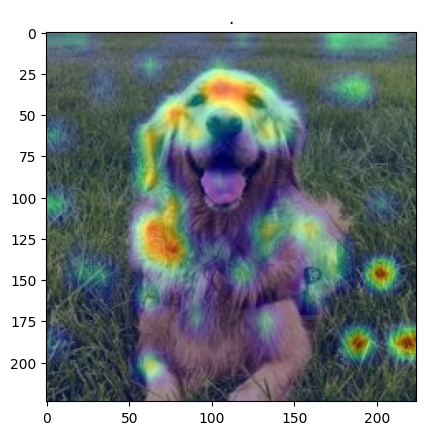

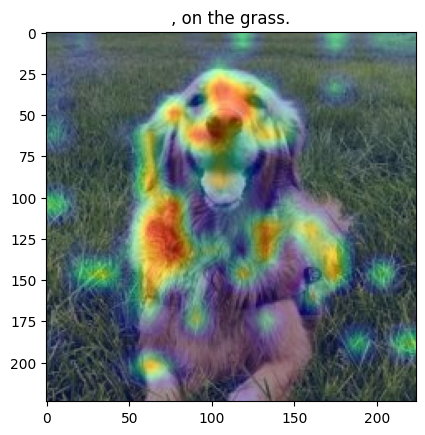

In [11]:
run(dataset = 'imagenet',
    image_path = './images/golden_retriever.png',
    texts_to_add = ['.', ', on the grass.'],
    class_nb = 207)

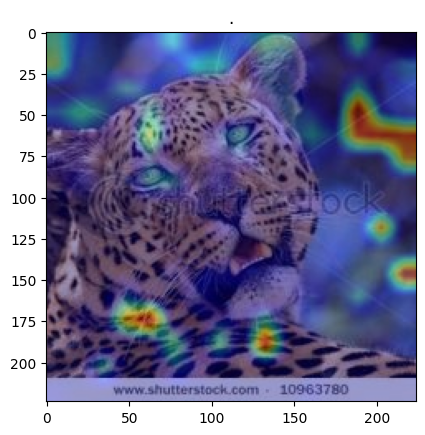

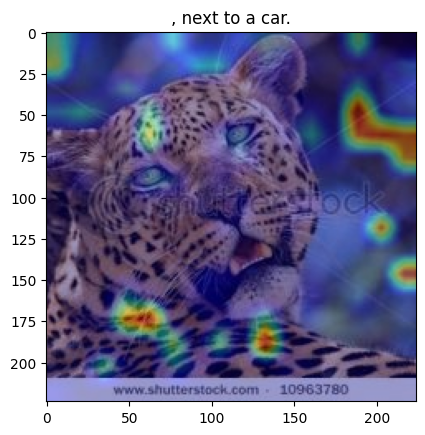

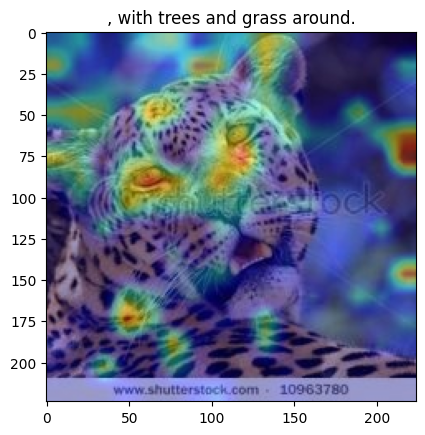

In [12]:
run(dataset = 'imagenet',
    image_path = './images/leopard1.jpeg',
    texts_to_add = ['.', ', next to a car.', ', with trees and grass around.'],
    class_nb = 288)

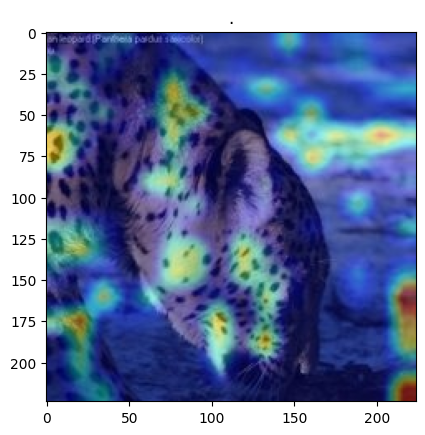

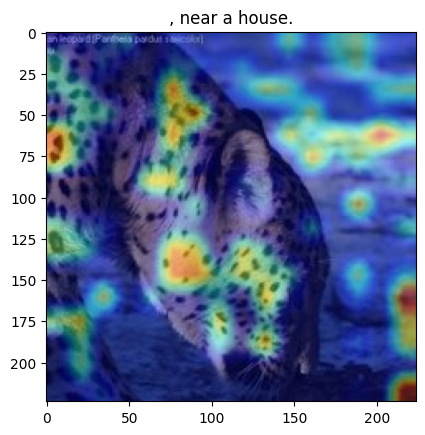

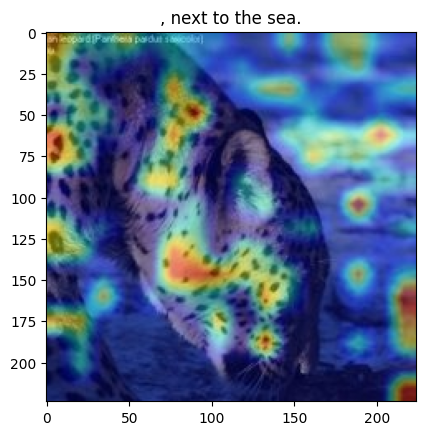

In [13]:
run(dataset = 'imagenet',
    image_path = './images/leopard2.jpeg',
    texts_to_add = ['.', ', near a house.', ', next to the sea.'],
    class_nb = 288)

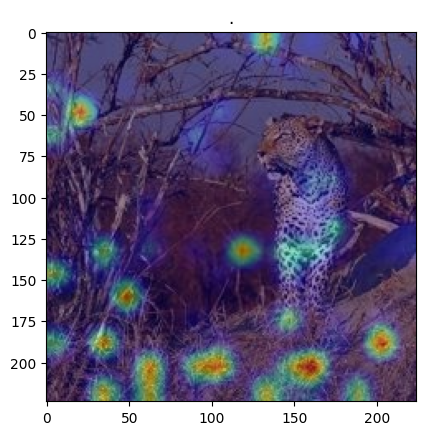

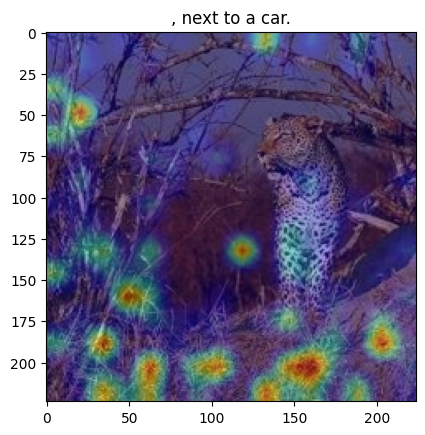

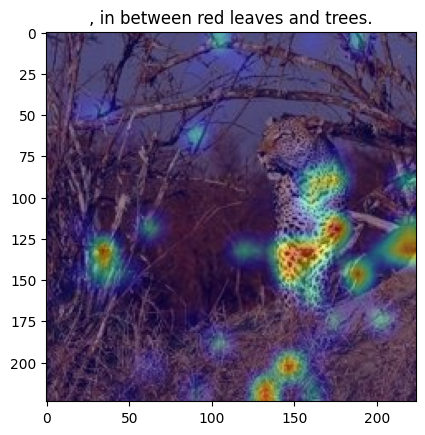

In [14]:
run(dataset = 'imagenet',
    image_path = './images/leopard3.jpeg',
    texts_to_add = ['.', ', next to a car.', ', in between red leaves and trees.'],
    class_nb = 288)

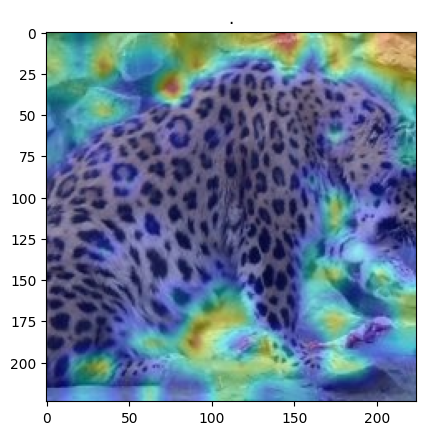

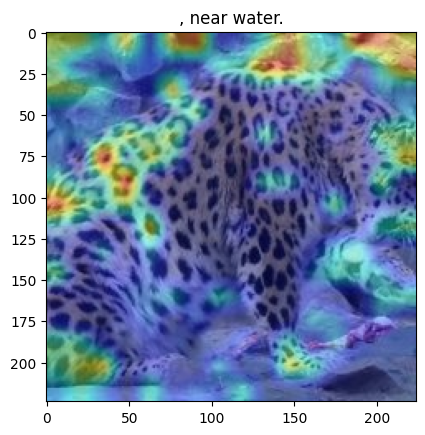

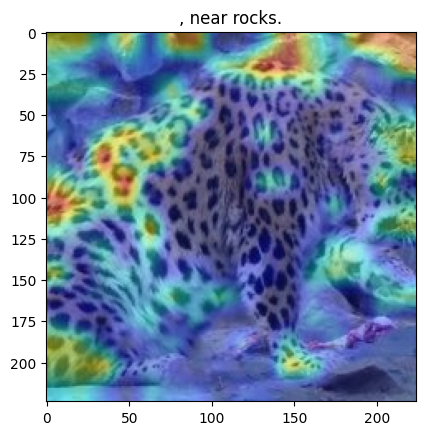

In [15]:
run(dataset = 'imagenet',
    image_path = './images/leopard4.jpeg',
    texts_to_add = ['.', ', near water.', ', near rocks.'],
    class_nb = 288)

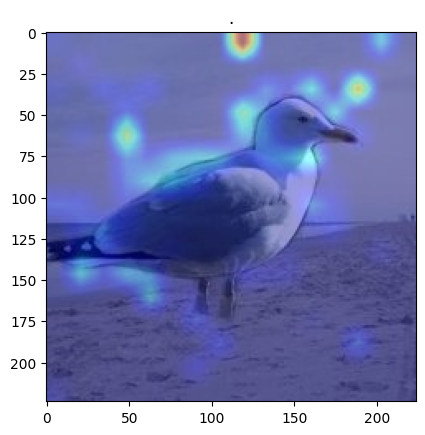

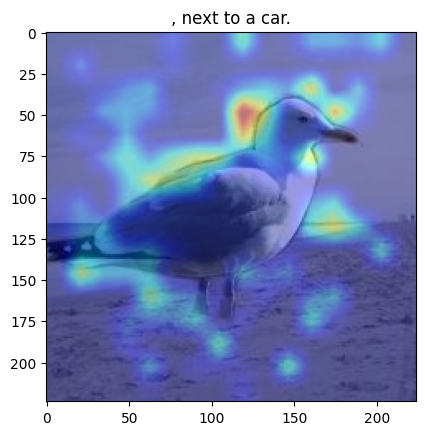

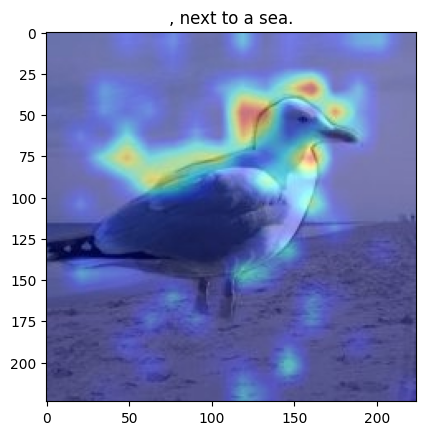

In [16]:
run(dataset = 'waterbirds',
    image_path = './images/waterbird1.jpeg',
    texts_to_add = ['.', ', next to a car.', ', next to a sea.'],
    class_nb = 1)

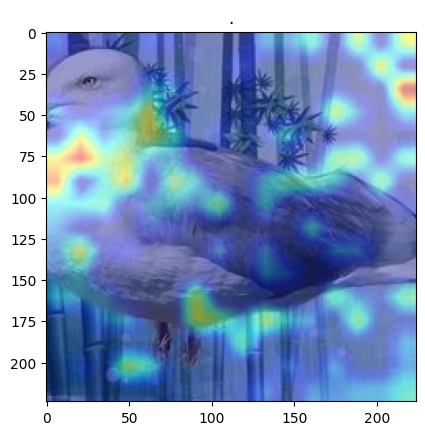

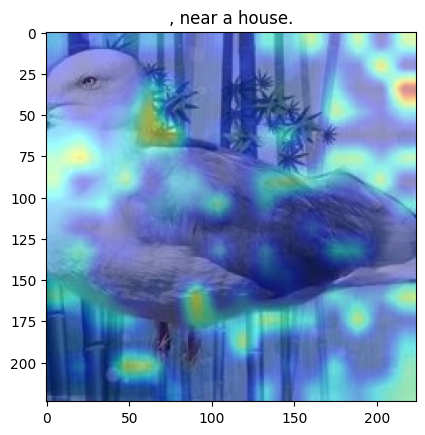

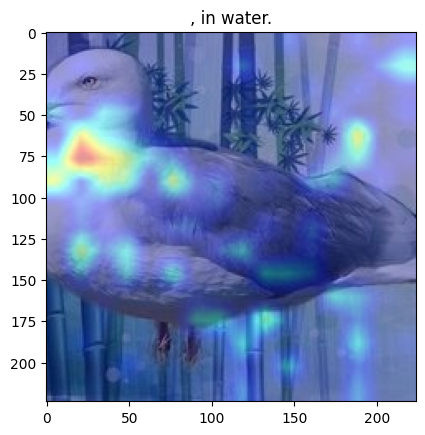

In [17]:
run(dataset = 'waterbirds',
    image_path = './images/waterbird2.jpeg',
    texts_to_add = ['.', ', near a house.', ', in water.'],
    class_nb = 1)

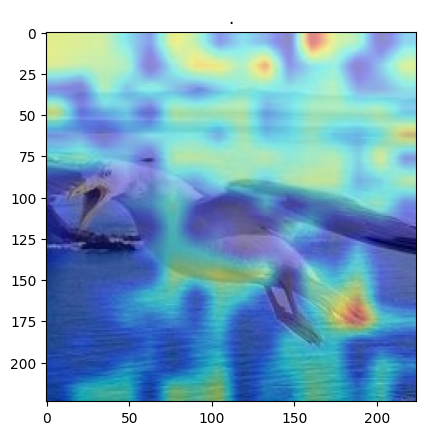

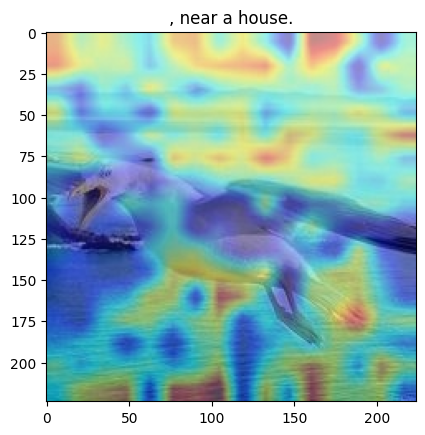

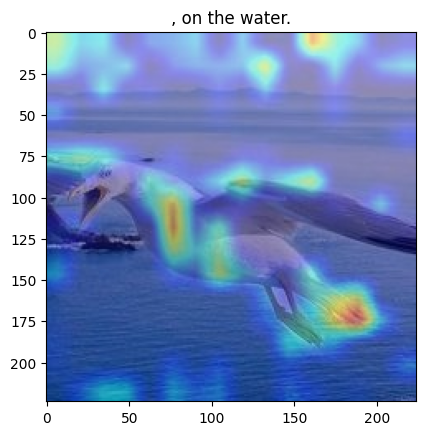

In [18]:
run(dataset = 'waterbirds',
    image_path = './images/waterbird3.jpeg',
    texts_to_add = ['.', ', near a house.', ', on the water.'],
    class_nb = 1)

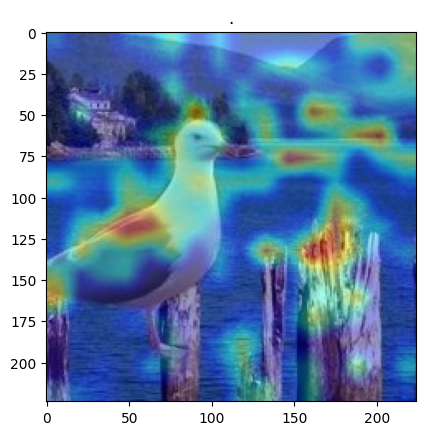

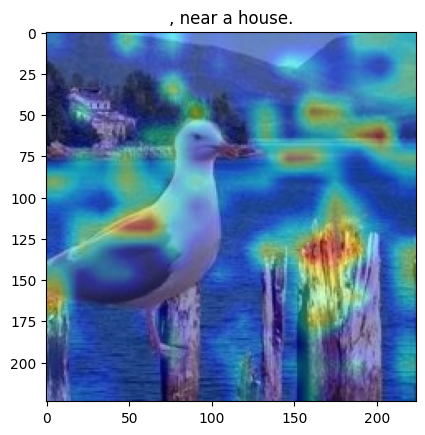

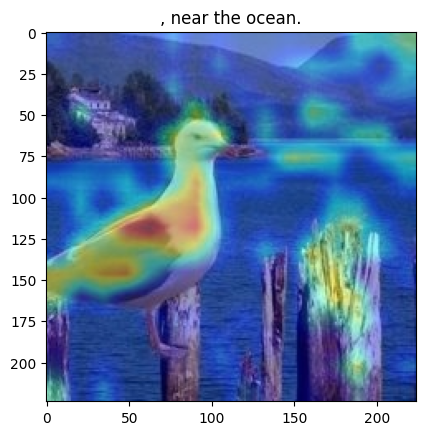

In [19]:
run(dataset = 'waterbirds',
    image_path = './images/waterbird4.jpeg',
    texts_to_add = ['.', ', near a house.', ', near the ocean.'],
    class_nb = 1)